In [1]:
# Import libraries
# !pip install yfinance
# !pip install fredapi


import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
from scipy.optimize import minimize
from fredapi import Fred

# Section 1: Define Tickers and Time Range

In [2]:
tickers = ['AMZN', 'VTI', 'VWO', 'VEA', 'BND', 'BJ', 'GS', 'IWM', 'FTNT', 'BX']

In [3]:
# Date setting 

end_date = datetime.today() # Set to today

start_date = end_date - timedelta(days = 5*30)  # Set to 5 years ago

print(start_date)

2024-05-09 17:35:23.701216


# Section 2: Download Adjusted Close Prices

In [4]:
adj_close_df = pd.DataFrame()
display(adj_close_df)

""


In [5]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Section 3: Calculate Lognormal Returns

In [6]:
# Calculate the lognormal returns for each ticker 

log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()   # Cleanse data with missing values

# Section 4: Calculate CoVariance Matrix

In [7]:
cov_matrix = log_returns.cov() * 252 # Use 252 because it is trading days during the year
print(cov_matrix)   

          AMZN       VTI       VWO       VEA       BND        BJ        GS  \
AMZN  0.083215  0.025585  0.019108  0.019337 -0.003350  0.011537  0.025248   
VTI   0.025585  0.018424  0.014522  0.016048  0.000233  0.012011  0.020954   
VWO   0.019108  0.014522  0.024956  0.017609  0.001002  0.009998  0.019281   
VEA   0.019337  0.016048  0.017609  0.021459  0.001206  0.011266  0.023109   
BND  -0.003350  0.000233  0.001002  0.001206  0.002739 -0.000137 -0.001927   
BJ    0.011537  0.012011  0.009998  0.011266 -0.000137  0.066765  0.005925   
GS    0.025248  0.020954  0.019281  0.023109 -0.001927  0.005925  0.061665   
IWM   0.026595  0.022626  0.019331  0.023048  0.000580  0.017712  0.034597   
FTNT  0.017368  0.004691  0.011302  0.009701 -0.000621 -0.010872  0.009288   
BX    0.024531  0.025238  0.018089  0.026352  0.003389  0.010126  0.037947   

           IWM      FTNT        BX  
AMZN  0.026595  0.017368  0.024531  
VTI   0.022626  0.004691  0.025238  
VWO   0.019331  0.011302  0.01

# Section 5: Define Portfolio Performance Metrics 

In [8]:
# Calculate the portfolio standard deviation
def std_dev(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [9]:
# Calculate the expected return

def ept_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [10]:
# Calculate the Sharpe Ratio
# Sharpe Ratio = (Portfolio Return - Risk Free Rate) / St.Dev

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(ept_return(weights, log_returns) - risk_free_rate) / std_dev(weights, cov_matrix)

# Section 6: Portfolio Optimization

In [11]:
# Set the risk-free rate according to textbook

# risk_free_rate = 0.02

In [12]:
# Get API from the FED

fred = Fred(api_key = '87f6fd22bd418ae0d91a107ad639d347')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

# Set the risk-free rate

risk_free_rate = ten_year_treasury_rate.iloc[-1]

# print(ten_year_treasury_rate)
print(risk_free_rate)

0.037200000000000004


In [13]:
# Define the function to minimize

# Negative Sharpe Ratio
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -(ept_return(weights, log_returns) - risk_free_rate) / std_dev(weights, cov_matrix)

In [14]:
# Set the constraints and bounds
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.3) for _ in range(len(tickers))] # List of tuples that set the lower and upper bounds for each weight.  

In [15]:
# Set initial weights

initial_weights = np.array([1/len(tickers)]*len(tickers))

display(initial_weights)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [16]:
# Optimize the weights to maximize Sharpe Ratio

optimized_results = minimize(neg_sharpe_ratio, 
                             initial_weights, 
                             args=(log_returns, cov_matrix, risk_free_rate), 
                             method='SLSQP', 
                             constraints=constraints, 
                             bounds=bounds)

In [17]:
# Get the optimal weights

optimal_weights = optimized_results.x


# Section 7: Analyze the Optimal Portfolio

In [18]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = ept_return(optimal_weights, log_returns)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AMZN: 0.0000
VTI: 0.0000
VWO: 0.2213
VEA: 0.0000
BND: 0.3000
BJ: 0.1170
GS: 0.0000
IWM: 0.0000
FTNT: 0.1718
BX: 0.1899
Expected Annual Return: 0.3661
Expected Volatility: 0.1155
Sharpe Ratio: 2.8480


# Section 8: Data visualization

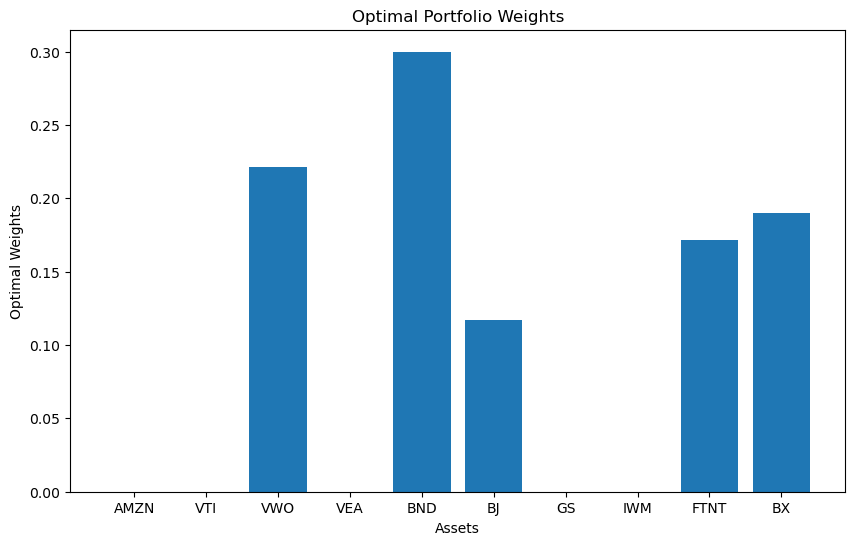

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()